## Introduction of Fairness Workflow Tutorial 
## (Dataset/Model Bias Check and Mitigation by Reweighing)

### Table of contents :
* [1 Introduction](#1.-Introduction)
* [2. Data preparation](#2.-Data-preparation)
* [3. Data fairness](#3.-Data-fairness)
	* [Data bias checking](#3.1-Bias-Detection)
    * [Data mitigation](#3.2-Bias-mitigation)
    * [Data-Fairness-comparison](#3.3-Data-Fairness-comparison) 
* [4. Model fairness on different ML models](#4.-Model-Fairness---on-different-ML-models)
* [5. Summary](#Summary)

## 1. Introduction

Welcome! 

With the proliferation of ML and AI across diverse set of real world problems, there is strong need to keep an eye on explainability and fairness of the impact of ML-AI techniques. This tutorial is one such attempt, offering glimpse into the world of fairness. 

We will walk you through an interesting case study in this tutorial. The aim is to familiarize you with one of the primary problem statements in Responsible AI: `Bias Detection and Mitigation`.

Bias is one of the basic problems which plagues datasets and ML models. After all, ML models are only as good as the data they see. 

Before we go into detailed explanation, we would like to give a sneak peak of the steps involved in the bias detection and mitigation process.

As illustrated in the picture, one must first prepare the data for analysis, detect bias, mitigate bias and observe the effect of bias mitigation objectively with data fairness and model fairness metrics.

In [1]:
# Preparation
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/gender_bias_mitigation

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/xai-bias-mitigation-workflow.png')
cv2_imshow(img)

### 1.1 Sources of bias :
There are many types of bias in data, which can exist in many shapes and forms, some of which may lead to unfairness [1]. 

Following are some examples of sources which introduce bias in datasets:

__Insufficient data :__ 
There may not be sufficient data overall or for some minority groups in the training data.<br>

__Data collection practice :__ 
Bad data collection practices could introduce bias even for large datasets. For example, high proportion of missing values for few features in some groups - indication of incomplete representation of these groups in the dataset.<br>

__Historical bias :__ 
Significant difference in the target distribution for different groups could also be present due to underlying human prejudices.

### 1.2 Bias detection :
There are multiple definitions of fairness and bias. Depending on the use case, appropriate fairness definition must be chosen to decide the criterion to detect bias in the model predictions. 
<br>

### 1.3 Bias mitigation :
There are three different approaches of bias-reduction intervention in the ML pipelines: 
1. Pre-processing
2. In-processing 
3. Post-processing

In this tutorial, we will see how to identify bias in [German credit dataset ](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)[7] and mitigate it with a `pre-processing algorithm (reweighing)`.<br>

### 1.4 German credit dataset :
[German Credit dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) has classification of people into good/bad credit categories. It has 1000 instances and 20 features.

In this dataset, one may observe age/gender playing significant role in the prediction of credit risk label. Instances with one gender may be favored and other gender[s] may be discriminated against by ML models. 

So, we must be aware of the following: <br>
* Training dataset may not be representative of the true population across age/gender groups
* Even if it is representative of the population, it is not fair to base any decision on applicant's age/gender

Let us get our hands dirty with the dataset. We shall determine presence of such biases in this dataset, try using a preprocessing algorithm to mitigate the bias and then evaluate model and data fairness.

In [2]:
import sys
import copy
import pandas as pd # for tabular data

import matplotlib.pyplot as plt # to plot charts
import seaborn as sns # to make pretty charts
from collections import defaultdict
import numpy as np # for math

# # sklearn to work with ML models, splitting the train-test data as well as imported metrics 
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc
sys.path.append('../responsible-ai/gender-bias-mitigation/')
from utils import *
%matplotlib inline

C:\Users\7000030346\Anaconda3\envs\xai\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Data preparation
#### Load dataset
First, let’s load [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data). Column names as listed in [`german.doc`](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc)

In [3]:
filepath = r'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
dataframe = load_dataset(filepath)
dataframe.head()

,status,month,credit_history,purpose,credit_amount,savings,employment,investment_as_income_percentage,personal_status,other_debtors,...,property,age,installment_plans,housing,number_of_credits,skill_level,people_liable_for,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Interesting! The dataframe has discrete numerical values and some encoded representations.
Let us quickly sift through features/attributes in this dataset.

##### Number of attributes/features : 
This dataset has a total of 20 (7 numerical + 13 categorical) attributes/features.

##### [Categorical attributes/features](https://en.wikipedia.org/wiki/Categorical_variable): 
13 categorical features: 'status', 'credit_history', 'purpose', 'savings', 'employment', 'personal_status', 'other_debtors', 'property', 'installment_plans', 'housing', 'skill_level', 'telephone', 'foreign_worker' <br>

##### Numerical attributes/features : 
Seven numerical features: 'month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits' and 'people_liable_for'. <br>

##### [Target variable](https://en.wikipedia.org/wiki/Dependent_and_independent_variables#:~:text=Known%20values%20for%20the%20target,but%20not%20in%20unsupervised%20learning.) : 
Credit coloumn represents target variable in this dataset. It has classification of good or bad credit label (good credit = 1, bad credit= 2). <br>

#### Nomenclature and properties relevant to Bias Detection and mitigation

Allow us to introduce some terms related to `bias detection and mitigation` in the context of dataset now.

##### Favourable & Unfavourable class :
Target values which are considered to be positive(good) may be called favourable class. The opposite may be called unfavourable class.

##### Protected attributes :
An attribute that partitions a population into groups with parity. Examples include race, gender, caste, and religion. Protected attributes are not universal, but are application specific [protected attributes](https://www.fairwork.gov.au/employee-entitlements/protections-at-work/protection-from-discrimination-at-work). Age and gender are the protected attributes in this dataset. <br>

##### Privileged class & Unprivileged class :
* Class in the protected attribute with majority is called privileged class. 
* The opposite is called unprivileged class.<br>

#### Dataset specific preprocessing
Data preprocessing in machine learning is a crucial step that helps enhance the quality of data to promote the extraction of meaningful insights from the data. 

For now let us specify the data specific preprocessing arguments to enhance the quality of data, for Ex: what is favourable & unfavourable labels, Protected attributes, privileged & unprivileged class ...etc to process the dataset.

In [4]:
# To keep it simple, in this tutorial, we shall try to determine whether there is gender bias in the dataset
# and mitigate that.
protected_attribute_names = ['gender']
privileged_classes = [['male']]

# derive the gender attribute from personal_status (you can refer the german.doc)
status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
              'A92': 'female', 'A95': 'female'}
dataframe['gender'] = dataframe['personal_status'].replace(status_map)

# target variable
label_name = 'credit'

favorable_label = 1.0  # good credit
unfavorable_label = 0.0  # bad credit
categorical_features = ['status', 'credit_history', 'purpose',
                        'savings', 'employment', 'other_debtors', 'property',
                        'installment_plans', 'housing', 'skill_level', 'telephone',
                        'foreign_worker']
features_to_drop = ['personal_status']

# dataset specific preprocessing
dataframe = preprocess_dataset(dataframe, label_name, protected_attribute_names,
                               privileged_classes, favorable_class=favorable_label,
                               categorical_features=categorical_features,
                               features_to_drop=features_to_drop)
dataframe.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,credit,gender,status=A11,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,6,1169,4,4,67,2,1,1,1,1,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,1,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,1,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,0,1,1,...,0,1,0,0,1,0,1,0,1,0


Split the preprocessed data set into train and test data i.e,how well does the trained model perform on unseen data (test data)?

In [5]:
train = dataframe.sample(frac=0.7, random_state=0)
test = dataframe.drop(train.index)

## 3. Data fairness

### 3.1 Bias Detection

Before creating ML models, one must first analyze and check for biases in dataset, as mentioned [earlier](#1.2-Bias-detection-:). In this tutorial, we will aim to achieve `Statistical Parity`. Statistical parity is achieved when all segments of protected class (e.g. gender/age) have equal rates of positive outcome.

#### 3.1.1 Statistical Parity Difference

`Statistical Parity` is checked by computing `Statistical Parity Difference (SPD)`. SPD is the difference between the rate of favorable outcomes received by unprivileged group compared to privileged group. Negative value indicates less favorable outcomes for unprivileged groups.

#### 3.1.2 Disparate Impact

`Disparate Impact (DI)` is a method for evaluating fairness by comparing the number of positive outcomes between unpriileged and privileged groups. It's calculated by dividing the proportion of positive outcomes for the unpriileged group by that of the privileged group. If the disadvantaged group receives positive outcomes that are less than 80% of the privileged group's proportion, it may indicate a violation. However, you may decide to increase this for your requirment.

Please look at the code below to get mathematical idea of SPD and DI. It is ok to skip through follow sections and come back later if you want to understand from holistic perspective:

In [6]:
# return `True` if the corresponding row satisfies the `condition` and `False` otherwise
def get_condition_vector(X, feature_names, condition=None):
    if condition is None:
        return np.ones(X.shape[0], dtype=bool)

    overall_cond = np.zeros(X.shape[0], dtype=bool)
    for group in condition:
        group_cond = np.ones(X.shape[0], dtype=bool)
        for name, val in group.items():
            index = feature_names.index(name)
            group_cond = np.logical_and(group_cond, X[:, index] == val)
        overall_cond = np.logical_or(overall_cond, group_cond)

    return overall_cond

##### Compute the number of positives

In [7]:
def get_num_pos_neg(X, y, w, feature_names, label, condition=None):
    """
    Returns number of optionally conditioned positives/negatives
    """

    y = y.ravel()
    cond_vec = get_condition_vector(X, feature_names, condition=condition)
    return np.sum(w[np.logical_and(y == label, cond_vec)], dtype=np.float64)

##### Compute the number of instances

In [8]:
def get_num_instances(X, w, feature_names, condition=None):
    cond_vec = get_condition_vector(X, feature_names, condition)

    return np.sum(w[cond_vec], dtype=np.float64)

##### Compute the rate of favourable result for a given condition

In [9]:
# Compute the base rate, :`Pr(Y = 1) = P/(P+N)
# Compute the persentage of favourable result for a given condition
def get_base_rate(X, y, w, feature_names, label, condition=None):
    return (get_num_pos_neg(X, y, w, feature_names, label, condition=condition)
            / get_num_instances(X, w, feature_names, condition=condition))

##### Compute fairness in training data

For computing the fairness of the data using SPD & DI, we need to specify and get some of the key inputs. So, let us specify what are privileged & unprivileged groups, Protected attributes, and instance weights to be considered in the train data set.

In [10]:
# target value
labels_train = train[label_name].values.copy()

# protected attributes
df_prot = train.loc[:, protected_attribute_names]
protected_attributes = df_prot.values.copy()
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]

# equal weights for all classes by default in the train dataset 
instance_weights = np.ones_like(train.index, dtype=np.float64)

now let's compute the fairness of data with respect to protected attribute

In [11]:
positive_privileged = get_base_rate(protected_attributes, labels_train, instance_weights,
                                    protected_attribute_names,
                                    favorable_label, privileged_groups)

positive_unprivileged = get_base_rate(protected_attributes, labels_train, instance_weights,
                                      protected_attribute_names,
                                      favorable_label, unprivileged_groups)

Let's look at favorable results for privileged & unprivileged groups in terms of statistical parity difference.

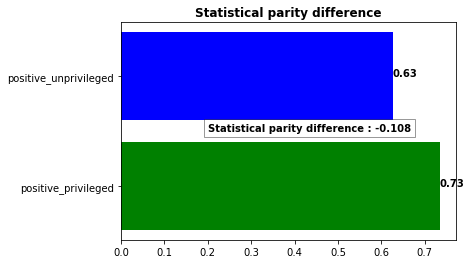

In [12]:
x = ["positive_privileged", "positive_unprivileged"]
y = [positive_privileged, positive_unprivileged]
plt.barh(x, y, color=['green', 'blue'])

for index, value in enumerate(y):
    plt.text(value, index, str(round(value, 2)), fontweight='bold')
plt.text(0.2, 0.5, "Statistical parity difference : " + str(
    round((positive_unprivileged - positive_privileged), 3)),
         bbox=dict(facecolor='white', alpha=0.4), fontweight='bold')
plt.title("Statistical parity difference", fontweight='bold')
plt.show()

Privileged group gets 10.8% more positive outcomes in the training dataset. This is `Bias`. Such Bias must be mitigated. 

In [13]:
def statistical_parity_difference(X, y, w, feature_names, label, privileged_groups,
                                  unprivileged_groups):
    """
    Compute difference in the metric between unprivileged and privileged groups.
    """

    positive_privileged = get_base_rate(X, y, w, feature_names, label, privileged_groups)
    positive_unprivileged = get_base_rate(X, y, w, feature_names, label, unprivileged_groups)
    return (positive_unprivileged - positive_privileged)

In [14]:
def disparate_impact(X, y, w, feature_names, label, privileged_groups,
                                  unprivileged_groups):
    """
    Compute the ratio of the metric between unprivileged and privileged groups.
    """

    positive_privileged = get_base_rate(X, y, w, feature_names, label, privileged_groups)
    positive_unprivileged = get_base_rate(X, y, w, feature_names, label, unprivileged_groups)
    return (positive_unprivileged/positive_privileged)

Let's store the fairnes of data in a variable 

In [15]:
original_spd = statistical_parity_difference(protected_attributes,
                                         labels_train, instance_weights,
                                         protected_attribute_names, favorable_label,
                                         privileged_groups, unprivileged_groups)
original_di = disparate_impact(protected_attributes,
                                         labels_train, instance_weights,
                                         protected_attribute_names, favorable_label,
                                         privileged_groups, unprivileged_groups)

#### 3.1.2 Analyze bias in the dataset
Let's understand how bias occurred in the dataset with respect to protected attribute. 
First, let's calculate the frequency count for categories of protected attributes in the training dataset.

In [16]:
# get the only privileged condition vector for the given protected attributes
# Values are `True` for the privileged values else 'False'
privileged_cond = get_condition_vector(
    protected_attributes,
    protected_attribute_names,
    condition=privileged_groups)

# Get the only unprivileged condition vector for the given protected attributes 
# Values are `True` for the unprivileged values else 'False)
unprivileged_cond = get_condition_vector(
    protected_attributes,
    protected_attribute_names,
    condition=unprivileged_groups)

In [17]:
# get the favorable(postive outcome) condition vector
# Values are `True` for the favorable values else 'False'
favorable_cond = labels_train.ravel() == favorable_label

# get the unfavorable condition vector
# Values are `True` for the unfavorable values else 'False'
unfavorable_cond = labels_train.ravel() == unfavorable_label

In [18]:
# combination of label and privileged/unprivileged groups

# Postive outcome for privileged group
privileged_favorable_cond = np.logical_and(favorable_cond, privileged_cond)

# Negative outcome for privileged group
privileged_unfavorable_cond = np.logical_and(unfavorable_cond, privileged_cond)

# Postive outcome for unprivileged group
unprivileged_favorable_cond = np.logical_and(favorable_cond, unprivileged_cond)

# Negative outcome for unprivileged group
unprivileged_unfavorable_cond = np.logical_and(unfavorable_cond, unprivileged_cond)

We need total number of instances, privileged, unprivileged, favorable outcomes, etc..

In [19]:
instance_count = train.shape[0]
privileged_count = np.sum(privileged_cond, dtype=np.float64)
unprivileged_count = np.sum(unprivileged_cond, dtype=np.float64)
favourable_count = np.sum(favorable_cond, dtype=np.float64)
unfavourable_count = np.sum(unfavorable_cond, dtype=np.float64)

privileged_favourable_count = np.sum(privileged_favorable_cond, dtype=np.float64)
privileged_unfavourable_count = np.sum(privileged_unfavorable_cond, dtype=np.float64)
unprivileged_favourable_count = np.sum(unprivileged_favorable_cond, dtype=np.float64)
unprivileged_unfavourable_count = np.sum(unprivileged_unfavorable_cond, dtype=np.float64)

Now, let us analyze above variables and see how the frequency of count is distributed for protected attribute.

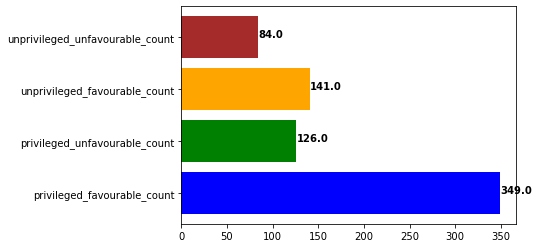

In [20]:
x = ["privileged_favourable_count", "privileged_unfavourable_count",
     "unprivileged_favourable_count", "unprivileged_unfavourable_count"]
y = [privileged_favourable_count, privileged_unfavourable_count, unprivileged_favourable_count,
     unprivileged_unfavourable_count]
plt.barh(x, y, color=['blue', 'green', 'orange', 'brown'])

for index, value in enumerate(y):
    plt.text(value, index,
             str(value), fontweight='bold')
plt.show()

##### Privileged and unprivileged group outcomes

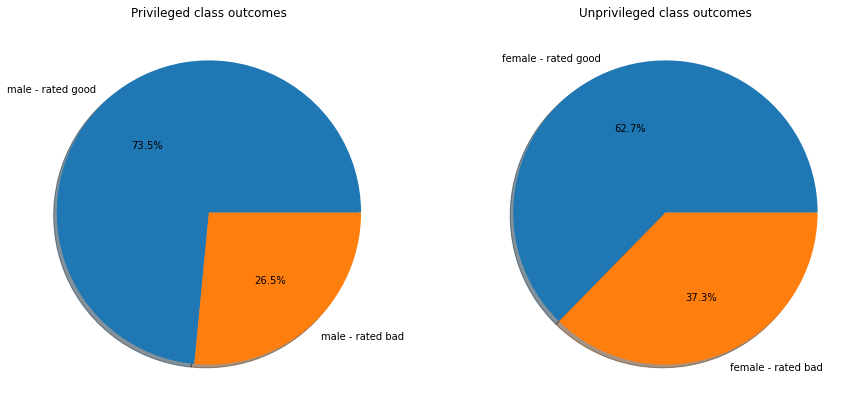

In [21]:
labels_privileged = ['male - rated good', 'male - rated bad']
sz_privileged = [privileged_favourable_count, privileged_unfavourable_count]
labels_unprivileged = ['female - rated good', 'female - rated bad']
sz_unpriveleged = [unprivileged_favourable_count, unprivileged_unfavourable_count]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.pie(sz_privileged, labels=labels_privileged, autopct='%1.1f%%', shadow=True)
ax1.title.set_text('Privileged class outcomes')

ax2.pie(sz_unpriveleged, labels=labels_unprivileged, autopct='%1.1f%%', shadow=True)
ax2.title.set_text('Unprivileged class outcomes')
plt.show()

Male is the privileged group with 73.5% favourable outcome and 26.5% unfavourable outcome.
Female is the unprivileged group with a 62.7% favourable outcome and 37.3% unfavourable outcome. <br>

So, there is bias against the unprivileged group (privileged group gets 10.8% more positive outcomes).

There may have been insufficient data for certain groups (gender attribute) at the feature (column) level resulting in an incomplete representation of these groups in the dataset. So, we could try to mitigate such bias using a pre-processing mitigation technique.


### 3.2 Bias mitigation
Pre-processing describes the set of data preparation and feature engineering steps before application of machine learning algorithms. Sampling, reweighing and suppression are examples of pre-processing bias mitigation techniques proposed in academic literature[2]. In this tutorial, we will focus on reweighing [3] technique that assigns weights to instances. 

#### 3.2.1 Reweighing algorithm

This approach assigns different weights to the examples based on the categories in protected attribute and outcomes such that bias is removed from the training dataset. Weights are based on frequency counts. But this technique is designed to work only with classifiers that can handle row-level weights.

#### Compute the reweighing weights (Equations)

***
1.&emsp;Privileged group with the favourable outcome : $W_\text{privileged favourable} = \displaystyle\frac{\#\{\text{favourable}\} \times \#\{\text{privileged}\}}{\#\{\text{all}\} \times \#\{\text{privileged favourable}\}}$ <br>

2.&emsp;Privileged group with the unfavourable outcome : $W_\text{privileged unfavourable} = \displaystyle\frac{\#\{\text{unfavourable}\} \times \#\{\text{prvileged}\}}{\#\{\text{all}\} \times \#\{\text{prvileged unfavourable}\}}$ <br>

3.&emsp;Unprivileged group with the favourable outcome : $W_\text{unprivileged favourable} = \displaystyle\frac{\#\{\text{favourable}\} \times \#\{\text{unprvileged}\}}{\#\{\text{all}\} \times \#\{\text{unprivileged favourable}\}}$ <br>

4.&emsp;Unprivileged group with the unfavourable outcome : $W_\text{unprivileged unfavourable} = \displaystyle\frac{\#\{\text{unfavourable}\} \times \#\{\text{unprivileged}\}}{\#\{\text{all}\} \times \#\{\text{unprivileged unfavourable}\}}$ <br>
***

In [22]:
# reweighing weights
weight_privileged_favourable = favourable_count * privileged_count / (instance_count * privileged_favourable_count)
weight_privileged_unfavourable = unfavourable_count * privileged_count / (instance_count * privileged_unfavourable_count)
weight_unprivileged_favourable = favourable_count * unprivileged_count / (instance_count * unprivileged_favourable_count)
weight_unprivileged_unfavourable = unfavourable_count * unprivileged_count / (instance_count * unprivileged_unfavourable_count)

In [23]:
transformed_instance_weights = copy.deepcopy(instance_weights)

In [24]:
transformed_instance_weights[privileged_favorable_cond] *= weight_privileged_favourable
transformed_instance_weights[privileged_unfavorable_cond] *= weight_privileged_unfavourable
transformed_instance_weights[unprivileged_favorable_cond] *= weight_unprivileged_favourable
transformed_instance_weights[unprivileged_unfavorable_cond] *= weight_unprivileged_unfavourable

Now that we have transformed instance_weights from reweighing algorithm, we can check how effective it is in removing bias by calculating the same metrics(Statistical Parity Difference & Disparate Impact) again.

In [25]:
mitigated_spd = statistical_parity_difference(protected_attributes,
                                          labels_train, transformed_instance_weights,
                                          protected_attribute_names, favorable_label,
                                          privileged_groups, unprivileged_groups)
mitigated_di = disparate_impact(protected_attributes,
                                          labels_train, transformed_instance_weights,
                                          protected_attribute_names, favorable_label,
                                          privileged_groups, unprivileged_groups)

### 3.3 Data Fairness comparison

let's compare the statistical parity difference(demogrpahic parity) of Original and Reweighing dataset.

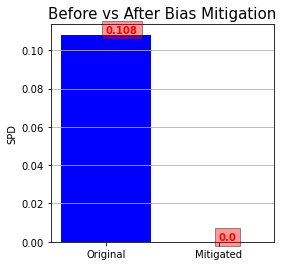

In [26]:
plot_fairness_comp(abs(original_spd),abs(mitigated_spd),metric="SPD")

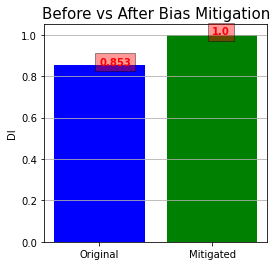

In [27]:
plot_fairness_comp(abs(original_di),abs(mitigated_di),metric="DI")

Reweighing algorithm has proven to be highly effective in reducing data bias, as it results in a Statistical Parity Difference of `zero` and a Disparate Impact of `one`. This algorithm enables us to address and minimize bias in the data by adjusting the weights of certain groups.

Now that we have both original and bias mitigated data, let's evaluate model fairness before and after bias mitigation.

## 4. Model Fairness - on different ML models

Model Fairness is a relatively new field in Machine Learning, 

Since predictive ML models have started making their way into the industry including sensitive medical, insurance and banking sectors, it has become prudent to implement strategies to ensure the fairness of those models to check discriminative behavior during predictions. Several definitions have been proposed [4][5][6] to evaluate model fairness.
In this tutorial, we will implement statistical parity (demographical parity) and Disparate Impact strategy to evaluate model fairness and detect any discriminative behavior during the prediction.

#### Statistical Parity (Demographic parity)
As discussed in [sec. 3.1.1](#3.1.1-Statistical-parity-difference), statistical parity states that the each segment of a protected class (e.g. gender) should receive the positive outcome at equal rates (the outcome is independent of a protected class). For example, the probability of getting admission to a college must be independent of gender. Let us assume the prediction of a machine learning model (Ŷ) to be independent of protected class A.

$$P(\hat{Y} \mid A=a) = P(\hat{Y} \mid A=a')$$, <br>
#### Disparate Impact
As discussed in [sec. 3.1.2](#3.1.1-Disparate-Impact), It's calculated by dividing the proportion of positive outcomes for the unpriileged group by that of the privileged group.

$$\frac{P(\hat{Y} \mid A=a')}{P(\hat{Y} \mid A=a)}$$,<br>
where a and a' are different sensitive attribute values (for example, gender male vs gender female).

##### Compute fairness of the different ML models
To compute model fairness (SPD & DI), let us specify privileged & unprivileged groups, protected attributes and instance weights to be considered in the test data set.

In [28]:
# protected attribute
df_prot_test = test.loc[:, protected_attribute_names]
protected_attributes_test = df_prot_test.values.copy()
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]
# equal weights for all classes by default in the testing dataset 
instance_weights_test = np.ones_like(test.index, dtype=np.float64)

Well, before training any ML model we need to standardize our dataset, when all numerical variables are scaled to a common range in the dataset, machine learning algorithms converge faster. So, we do scaling with the standardization technique in this tutorial.

In [29]:
# split the features and labels for both train and test data
feature_names = [n for n in train.columns if n not in label_name]
X_train, X_test, Y_train, Y_test = train[feature_names].values.copy(), test[
    feature_names].values.copy(), train[label_name].values.copy(), test[label_name].values.copy()
# standardize the inputs 
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)

It is important to compare fairness and performance of multiple different machine learning algorithms before and after bias mitigation. We shall do that for Logistic Regression, Decision Trees, Random Forest classifier, XG Boost and SVM in this tutorial.

In [30]:
# prepare list of models
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier(random_state=0)))
models.append(('RF', RandomForestClassifier(random_state=4)))
models.append(('XGB', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')))
models.append(('SVM', SVC(probability=True)))

let's compute the Performance & Model Fairness before after bias mitigation on the above models
First let's start trining the baseline models

In [31]:
ml_models, accuracy_list, roc_auc_list, spd_list, di_list = [], [], [], [], []
for name, model in models:
    # evaluate the base model
    clf = train_model(model, X_train, Y_train,sample_weight=instance_weights)
    y_score = clf.predict_proba(X_test)[:, 1]
    predicted = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, predicted)
    fpr, tpr, _ = roc_curve(Y_test, predicted)
    roc_auc = auc(fpr, tpr)
    # compute SPD for base model
    spd = statistical_parity_difference(protected_attributes_test,
                                                  predicted, instance_weights_test,
                                                  protected_attribute_names, favorable_label,
                                                  privileged_groups, unprivileged_groups)
    # compute DI for base model
    di = disparate_impact(protected_attributes_test,predicted, instance_weights_test,
                          protected_attribute_names, favorable_label,
                          privileged_groups, unprivileged_groups)
    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    spd_list.append(spd)
    di_list.append(di)
    ml_models.append(name)

To facilitate comparison of model performance and fairness, we will store all the relevant values in a dictionary

In [32]:
before_debiasing = defaultdict(dict)
before_debiasing["SPD"] = spd_list
before_debiasing["DI"] = di_list
before_debiasing["Accuracy"] = accuracy_list
before_debiasing["AUC"] = roc_auc_list

In [33]:
ml_models, accuracy_list, roc_auc_list, spd_list, di_list = [], [], [], [], []
for name, model in models:
    # evaluate the mitgated model
    clf = train_model(model, X_train, Y_train,sample_weight=transformed_instance_weights)
    y_score = clf.predict_proba(X_test)[:, 1]
    predicted = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, predicted)
    fpr, tpr, _ = roc_curve(Y_test, predicted)
    roc_auc = auc(fpr, tpr)
    # compute SPD for base model
    spd = statistical_parity_difference(protected_attributes_test,
                                                  predicted, instance_weights_test,
                                                  protected_attribute_names, favorable_label,
                                                  privileged_groups, unprivileged_groups)
    # compute DI for base model
    di = disparate_impact(protected_attributes_test,predicted, instance_weights_test,
                          protected_attribute_names, favorable_label,
                          privileged_groups, unprivileged_groups)
    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    spd_list.append(spd)
    di_list.append(di)
    ml_models.append(name)

In [34]:
after_debiasing = defaultdict(dict)
after_debiasing["SPD"] = spd_list
after_debiasing["DI"] = di_list
after_debiasing["Accuracy"] = accuracy_list
after_debiasing["AUC"] = roc_auc_list

##### Graphical Comparison of fairness & performance

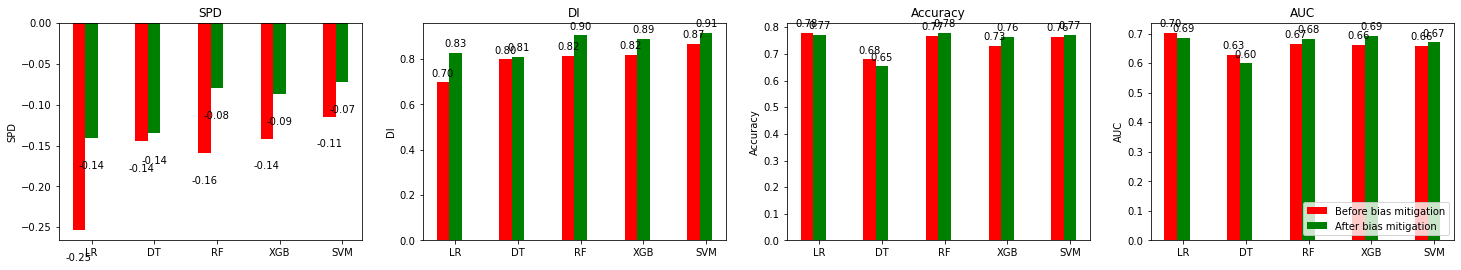

In [35]:
def autolabel(rects, axes):
        for rect in rects:
            h = rect.get_height()
            if h < 0:
                axes.text(rect.get_x() + rect.get_width() / 2., h - 0.04, '%.2f' % float(h),
                          ha='center', va='bottom')
            else:
                axes.text(rect.get_x() + rect.get_width() / 2., 1.02 * h, '%.2f' % float(h),
                          ha='center', va='bottom')
ind = np.arange(len(ml_models))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, axs = plt.subplots(1, 4, figsize=(25, 4))

for ax,metric in zip (axs.ravel(),after_debiasing.keys()):
    fairness_base_bar = ax.bar(ind, before_debiasing[metric], width, color='r',
                        label='Before bias mitigation')
    fairness_mitigated_bar = ax.bar(ind + width, after_debiasing[metric], width, color='g',
                                     label='After bias mitigation')
    ax.set_ylabel(metric)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(ml_models)
    ax.title.set_text(metric)
    autolabel(fairness_base_bar, axes=ax)
    autolabel(fairness_mitigated_bar, axes=ax)
plt.legend(loc ="lower right")
plt.show()

It can be observed that the classifiers learned on the bias mitigated data produce less discriminatory results (fairness improved) as compared to the biased data; If you consider the statistical parity difference (SPD) metric, logistic regression (LR) model trained on biased data classifies the future data objects with `-0.25` discrimination, indicating more positive outcomes for the privileged group and a biased model against the unprivileged group. However, after applying the Reweighing algorithm, the discrimination goes down to `-0.14`, indicating an improvement in fairness. Similarly, the Disparate Impact metric also shows improvement in fairness after bias mitigation. Though there is bias in favor of the privileged group after reweighing, it is much lesser and keeps the ML practitioner informed about the amount of bias in order to make calculated decisions. Besides, it can be observed, there is no significant drop in the Accuracy and AUC for any algorithm after bias mitigation. This is good and it makes strong case for `Bias Detection and Mitigation`. 

Well, let us visualize the detailed flow of everything we learned in this tutorial:



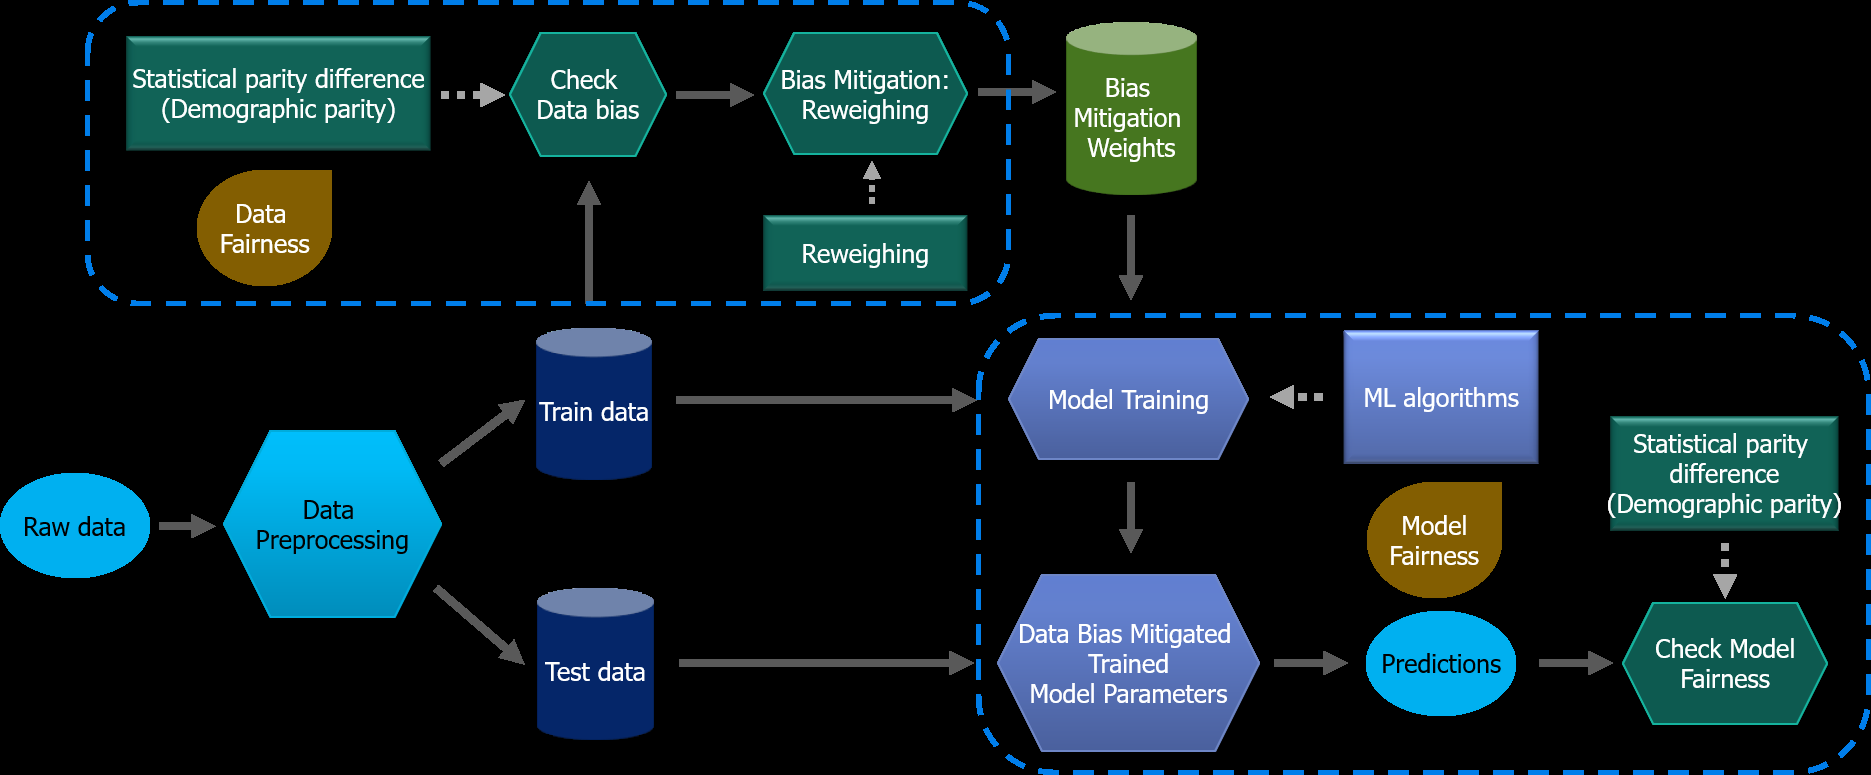

In [36]:
from google.colab.patches import cv2_imshow
img2 = cv2.imread('images/xai-bias-mitigation.png')
cv2_imshow(img2)



 In short, we can summarize the procedure in the following 4 steps:
 1. Prepare the data for analysis
 2. Detect bias in the data set
 3. Mitigate bias in the data set
 4. Observe the fairness of the model before and after bias mitigation

### Summary

In this tutorial, we have tried to give a gentle introduction to gender bias detection and mitigation to enthusiasts of Responsible AI. Although there are many ways to detect and mitigate bias, we have only illustrated one simple way to detect bias and mitigate it with `Reweighing` algorithm in this tutorial. We plan to create and open-source tutorials illustrating other ways of bias detection and mitigation in the future.

### References
[1] [Ninareh Mehrabi, Fred Morstatter, Nripsuta Saxena, Kristina Lerman, Aram Galstyan. A Survey on Bias and Fairness in Machine Learning. arXiv:1908.09635
](https://arxiv.org/abs/1908.09635)   
[2] Kamiran F, Calders T (2009a) Classifying without discriminating. In: Proceedings of IEEE IC4 international conference on computer, Control & Communication. IEEE press<br>
[3] [Kamiran, Faisal and Calders, Toon. Data preprocessing techniques for classification without discrimination](https://link.springer.com/content/pdf/10.1007%2Fs10115-011-0463-8.pdf). Knowledge and Information Systems, 33(1):1–33, 2012<br>
[4] Hardt, M., Price, E., and Srebro, N. (2016). “Equality of opportunity in supervised learning,” in Advances in Neural Information Processing Systems, eds D. D. Lee, M. Sugiyama, U. V. Luxburg, I. Guyon, and R. Garnett (Barcelona: Curran Associates, Inc.), 3315–3323.<br>
[5] Chouldechova, A. (2017). Fair prediction with disparate impact: a study of bias in recidivism prediction instruments. Big Data 5, 153–163. doi: 10.1089/big.2016.0047<br>
[6] Zafar, M. B., Valera, I., Gomez Rodriguez, M., and Gummadi, K. P. (2017a). “Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment,” in Proceedings of the 26th International Conference on World Wide Web (Perth: International World Wide Web Conferences Steering Committee), 1171–1180. doi: 10.1145/3038912.3052660<br>
[7] https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29 <br>